# Problem 1: Predicting Number of Attacks Next Month

## Checking pre prerequisites before starting to build the model

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme (style="darkgrid")


In [92]:
# Load the dataset
df = pd.read_csv("model1_dataset.csv")

prob1_dataset = df

In [93]:
# One hot encoding the model column as it is an object dt which the model cannot read
prob1_dataset = pd.get_dummies(prob1_dataset, columns=['model'])


In [94]:
# Dropping all null values
prob1_dataset = prob1_dataset.dropna()

## Training the model

Base model no hyperparameters

RMSE: 5.38
R²: -0.2021


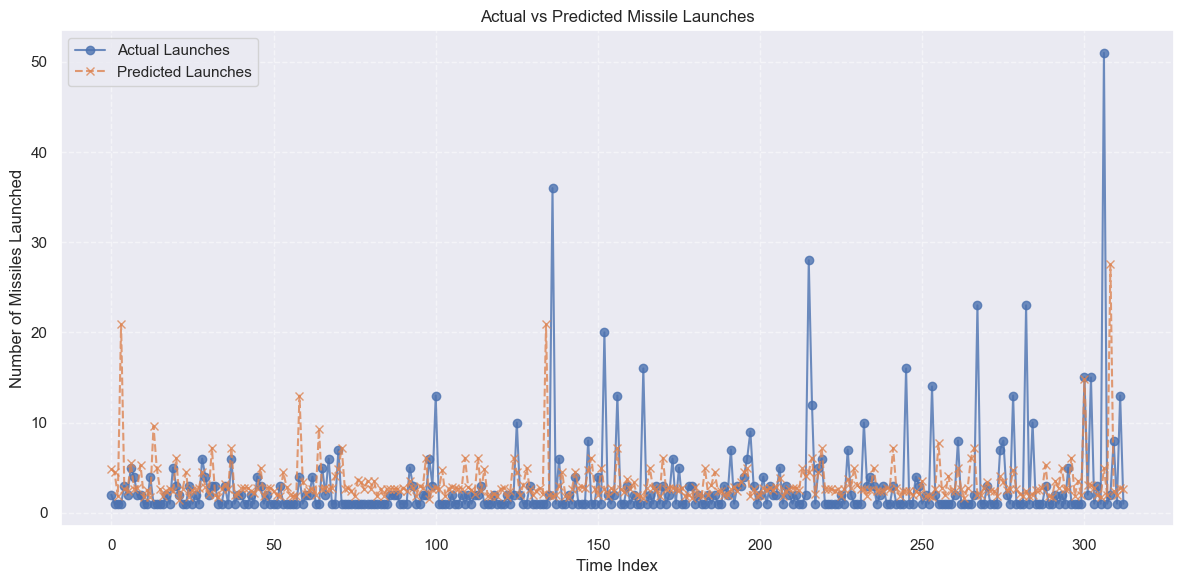

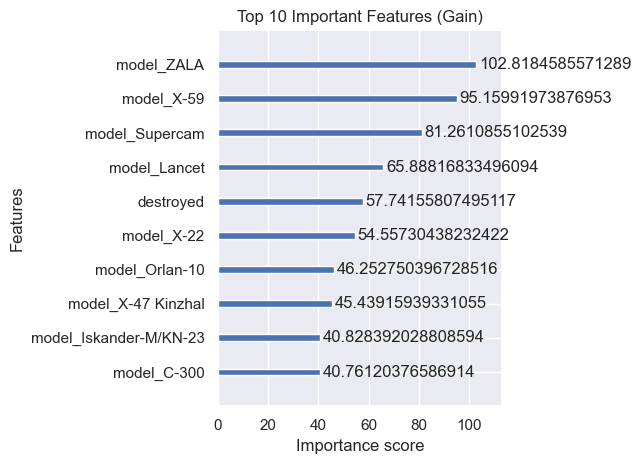

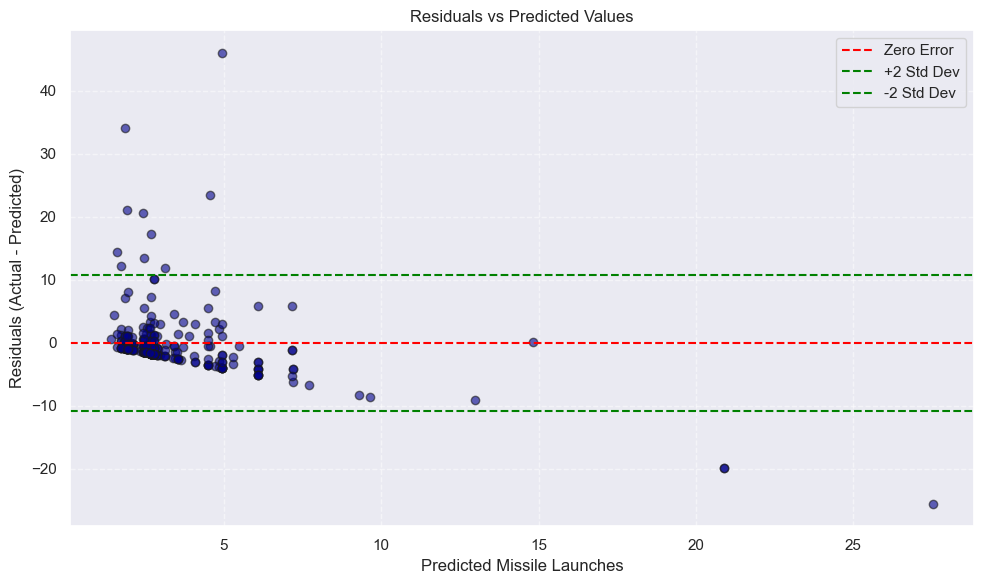

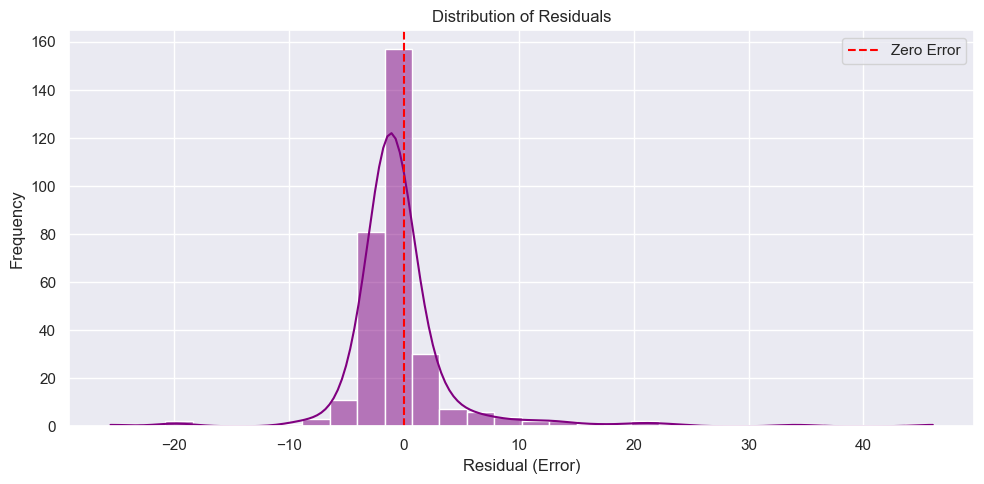

Residual Plot RMSE: 5.38


In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data
X = prob1_dataset.drop(columns=['launched', 'launched_next_month', 'time_start'])
y = prob1_dataset['launched_next_month']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

import seaborn as sns

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Launches', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred, label='Predicted Launches', marker='x', linestyle='--', alpha=0.8)
plt.title('Actual vs Predicted Missile Launches')
plt.xlabel('Time Index')
plt.ylabel('Number of Missiles Launched')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Feature importance plot
plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features (Gain)")
plt.tight_layout()
plt.show()

# Residuals Plot (for base model prediction)
residuals = y_test.values - y_pred
std_residuals = np.std(residuals)

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='darkblue', alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error')
plt.axhline(y=std_residuals * 2, color='green', linestyle='--', label='+2 Std Dev')
plt.axhline(y=-std_residuals * 2, color='green', linestyle='--', label='-2 Std Dev')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Missile Launches')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Error)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Print RMSE again
print(f"Residual Plot RMSE: {rmse:.2f}")




### Second model using some hyperparameters 
    Which led to a much lower RMSE and a better accuracy R2 score but still not great accuracy.
    I concluded the dataset was too small and inconsistent as each fold could only have so much data in it, 
    due to small data pool leaving very little learnt from each training set. and a lack of pattern recognition by the model.

Fold 1 RMSE: 1.52, R²: -9.3546
Fold 2 RMSE: 1.61, R²: -1.8162
Fold 3 RMSE: 4.05, R²: -12.4333
Fold 4 RMSE: 2.22, R²: -4.3662
Fold 5 RMSE: 1.73, R²: -1.6197
Fold 6 RMSE: 1.91, R²: -0.7092
Fold 7 RMSE: 2.24, R²: -0.3164
Fold 8 RMSE: 2.20, R²: -0.8998
Fold 9 RMSE: 1.65, R²: -0.2202
Fold 10 RMSE: 2.13, R²: -0.0191
Fold 11 RMSE: 0.97, R²: 0.1799
Fold 12 RMSE: 1.72, R²: -12.3620
Fold 13 RMSE: 2.11, R²: -0.5291
Fold 14 RMSE: 0.95, R²: 0.2044
Fold 15 RMSE: 1.15, R²: 0.3077
Fold 16 RMSE: 1.68, R²: -1.2959
Fold 17 RMSE: 1.77, R²: -0.4694
Fold 18 RMSE: 2.36, R²: -1.9082
Fold 19 RMSE: 2.61, R²: -1.3603
Fold 20 RMSE: 1.23, R²: -5.0655
Fold 21 RMSE: 0.85, R²: -4.2494
Fold 22 RMSE: 1.30, R²: -1.8749
Fold 23 RMSE: 1.71, R²: -0.8721
Fold 24 RMSE: 1.52, R²: -0.8811
Fold 25 RMSE: 0.65, R²: 0.2367
Fold 26 RMSE: 1.63, R²: -1.1867
Fold 27 RMSE: 0.87, R²: -0.3772
Fold 28 RMSE: 1.05, R²: -3.9945
Fold 29 RMSE: 5.15, R²: -0.2766
Fold 30 RMSE: 1.05, R²: -3.9500
Fold 31 RMSE: 0.70, R²: -0.0490
Fold 32 RMSE: 1.11,

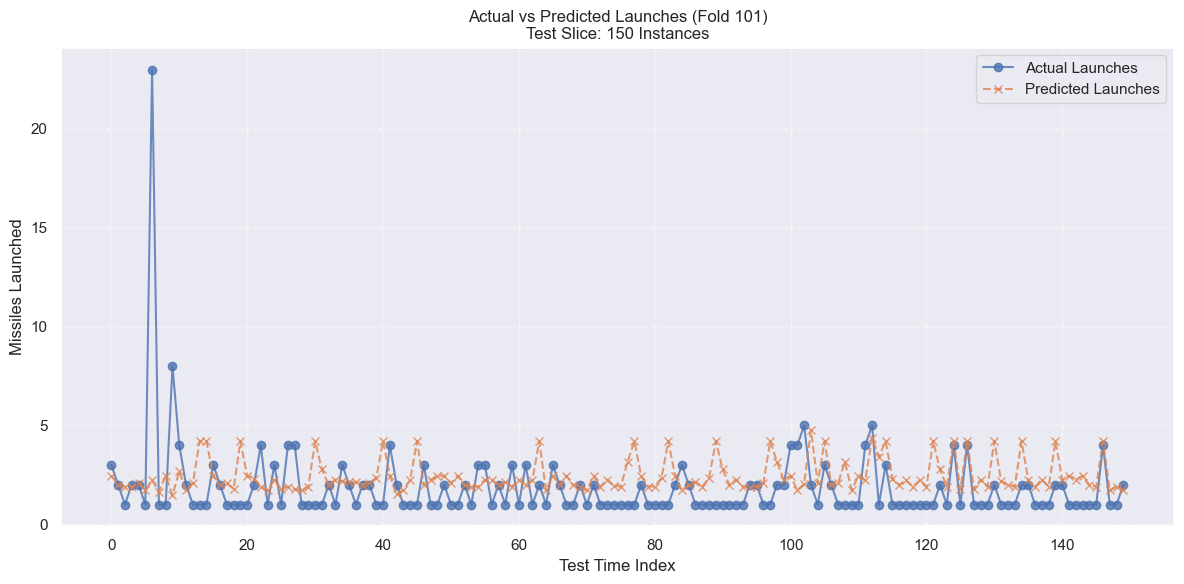

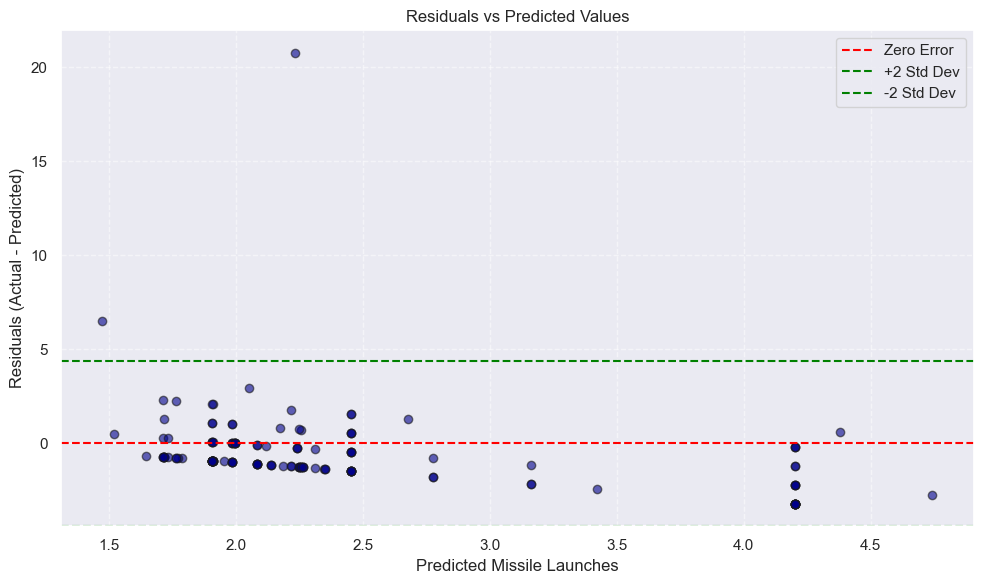

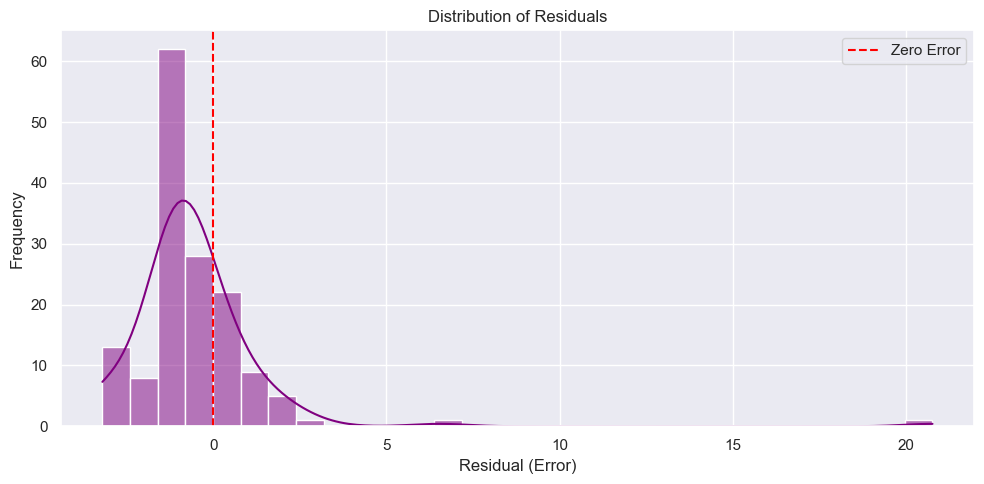

Residual Plot RMSE: 2.27


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Features and target
X = prob1_dataset.drop(columns=['launched', 'launched_next_month', 'time_start'])
y = prob1_dataset['launched_next_month']

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=250)

# Initialize lists to store scores
rmse_scores = []
r2_scores = []
best_rmse = float("inf")
best_rmse_fold = None
best_train_idx = None

# Perform time series cross-validation
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Store scores
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    # Print fold results
    print(f"Fold {fold} RMSE: {rmse:.2f}, R²: {r2:.4f}")
    
    # Check for best RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_rmse_fold = fold
        best_train_idx = train_idx

# Print overall performance
print("\n Overall Performance")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average R²: {np.mean(r2_scores):.4f}")
print(f"\nBest RMSE Fold: {best_rmse_fold} with RMSE = {best_rmse:.2f}")

# Use best fold for a larger test slice
start_test_idx = best_train_idx[-1] + 1
test_slice_size = 150
end_test_idx = min(start_test_idx + test_slice_size, len(X))

# Ensure the end index does not exceed the dataset length
X_train = X.iloc[best_train_idx]
y_train = y.iloc[best_train_idx]
X_test_large = X.iloc[start_test_idx:end_test_idx]
y_test_large = y.iloc[start_test_idx:end_test_idx]

# Train the model on the best fold's training data and predict on the larger test slice
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)
y_pred_large = model.predict(X_test_large)

# Evaluate the larger test slice
rmse_large = np.sqrt(mean_squared_error(y_test_large, y_pred_large))
r2_large = r2_score(y_test_large, y_pred_large)

# Print evaluation results for the larger test slice
print(f"\n Evaluation on Larger Test Slice")
print(f"RMSE: {rmse_large:.2f}")
print(f"R²: {r2_large:.4f}")

import matplotlib.ticker as mtick

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_large.values, label='Actual Launches', marker='o', linestyle='-', alpha=0.8)
plt.plot(y_pred_large, label='Predicted Launches', marker='x', linestyle='--', alpha=0.8)
plt.title(f'Actual vs Predicted Launches (Fold {best_rmse_fold})\nTest Slice: {test_slice_size} Instances')
plt.xlabel('Test Time Index')
plt.ylabel('Missiles Launched')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Residuals Calculation
residuals = y_test_large.values - y_pred_large
std_residuals = np.std(residuals)

# Residuals vs Predicted Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_large, residuals, color='darkblue', alpha=0.6, edgecolor='k')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error')
plt.axhline(y=std_residuals * 2, color='green', linestyle='--', label='+2 Std Dev')
plt.axhline(y=-std_residuals * 2, color='green', linestyle='--', label='-2 Std Dev')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Missile Launches')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Error)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Final RMSE print
print(f"Residual Plot RMSE: {rmse_large:.2f}")

